In [133]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math
from PIL import Image

In [14]:
content = Image.open('images/owl_on_branch.jpg')
style = Image.open('images/african_art.jpg')

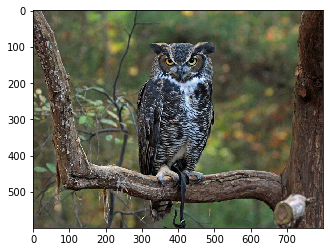

In [15]:
# Just show the content image
plt.imshow(content)
plt.show()

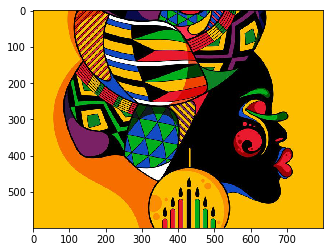

In [16]:
# Just show the style image
plt.imshow(style)
plt.show()

In [42]:
# Convert the images to numpy arrays
content_array = np.asarray(content)
style_array = np.asarray(style)
assert content_array.shape == style_array.shape

# Get the HEIGHT and WIDTH in case it is needed later
SHAPE = content_array.shape


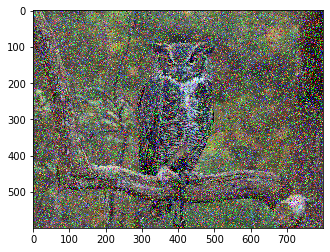

In [43]:
# Add noise to the content image to generate what the output should be
gauss_noise = np.random.normal(0, 255, content_array.shape).astype('uint8')
gauss_noise = gauss_noise * np.random.normal(0, 1, content_array.shape).astype('uint8')
gen_img = np.add(content_array, gauss_noise)
plt.imshow(Image.fromarray(gen_img))
plt.show()

In [76]:
vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet", pooling = "avg", input_shape = SHAPE)
vgg.trainable = False

In [47]:
# Print the layers in the VGG19 network
for layer in vgg.layers:
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_average_pooling2d


In [100]:
# Layers to use when computing the cost
CONTENT_LAYERS = [
    ('block4_conv2', 0.2),
]

STYLE_LAYERS = [
    ('block1_conv2', 0.2),
    ('block2_conv2', 0.2),
    ('block3_conv2', 0.2),
    ('block4_conv2', 0.2),
    ('block5_conv2', 0.2)
]

In [86]:
def normalize_data(image):
    return tf.keras.applications.vgg19.preprocess_input(image)

norm_content = normalize_data(content_array).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])
norm_style = normalize_data(style_array).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])
norm_gen_img = normalize_data(gen_img).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])


In [68]:
# Only need to run this if you want to test VGG19

# Full VGG19 to make sure it is working
vgg_test = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg_test(tf.image.resize(norm_content, (224, 224)))
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 3us/step


[('great_grey_owl', 0.9612897),
 ('kite', 0.030206366),
 ('bald_eagle', 0.0033779503),
 ('ruffed_grouse', 0.002057377),
 ('black_grouse', 0.00041117807)]

In [75]:
vgg.get_layer('block4_conv4').output


<tf.Tensor 'input_1:0' shape=(None, 600, 800, 3) dtype=float32>

In [95]:
# Create a model for the style and the content using VGG
def vgg_model_output(layers):
    layer_outputs = []
    for layer, weight in layers:
        layer_outputs.append(vgg.get_layer(layer).output)
    return tf.keras.Model([vgg.input], layer_outputs)



(1, 600, 800, 64)
(1, 300, 400, 128)
(1, 150, 200, 256)
(1, 75, 100, 512)
(1, 37, 50, 512)
(75, 100, 512)


In [ ]:
norm_content = normalize_data(content_array).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])
norm_style = normalize_data(style_array).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])
norm_gen_img = normalize_data(gen_img).reshape(1, SHAPE[0], SHAPE[1], SHAPE[2])

In [129]:
a_gen_content_layers = vgg_model_output(CONTENT_LAYERS)(norm_gen_img)
a_gen_style_layers = vgg_model_output(STYLE_LAYERS)(norm_gen_img)
a_content_layers = vgg_model_output(CONTENT_LAYERS)(norm_content)
a_style_layers = vgg_model_output(STYLE_LAYERS)(norm_style)

In [131]:
# Compute the cost of the content given the activations
def content_cost(a_gen_img, a_content_img):
    total_cost = 0
    for layer in range(0, len(a_gen_img)):
        # Get the output layer
        a_G_layer =  a_gen_img[layer] #tf.reshape(a_gen_img[layer], [1, a_gen_img[layer][0], a_gen_img[layer][1], a_gen_img[layer][2]])
        a_C_layer = a_content_img[layer] # tf.reshape(a_content_img[layer], 1, a_content_img[layer][0], a_content_img[layer][1], a_content_img[layer][2])
        
        # Get the dimensions
        n_H, n_W, n_C = a_G_layer.get_shape().as_list()
        
        # Unroll the activations
        unrolled_aG = tf.reshape(a_G_layer, [1, n_W * n_H, n_C])
        unrolled_aC = tf.reshape(a_C_layer, [1, n_W * n_H, n_C])
        
        # Compute the cots and add it to total_cost
        total_cost += 1/(4 * n_W * n_H * n_C) * tf.math.reduce_sum(tf.math.square(tf.subtract(unrolled_aG, unrolled_aC)))
    
    print(total_cost.numpy())
    return total_cost
        
#     for output in style_model(norm_style):
#         print(output.shape)

#     for output in content_model(norm_content):
#         print(output.shape)

#     for output in style_model(norm_gen_img):
#         print(output.shape)

#     for output in content_model(norm_gen_img):
#         print(output.shape)

content_cost(a_gen_content_layers, a_content_layers)

87631.805


<tf.Tensor: shape=(), dtype=float32, numpy=87631.805>

In [140]:
# Compute the gram matrix
# Want to have the gram matrix in shape n_C by n_C
# Input matrix should be n_C x (n_W * n_H)
def compute_gram(matrix):
    return tf.linalg.matmul(matrix, tf.transpose(matrix))


In [144]:
# Compute style cost on a layer
def style_cost_layer(a_gen_layer, a_style_layer, n_C, n_W, n_H):
    G_a_gen_layer = compute_gram(a_gen_layer)
    G_a_style_layer = compute_gram(a_style_layer)
    return (1/(4 * math.pow(n_C, 2) * math.pow(n_W * n_H, 2))) * tf.reduce_sum(tf.math.square(tf.math.subtract(G_a_gen_layer, G_a_style_layer)))

In [149]:
# Compute style cost on all of the out layers from the VGG19 model
def total_style_cost(a_gen_style_layers, a_style_layers):
    total_cost = 0.0
    for layer in range(0, len(a_gen_style_layers)):
        a_gen_style_layer = a_gen_style_layers[layer]
        a_style_layer = a_style_layers[layer]
        m, n_H, n_W, n_C = a_gen_style_layer.get_shape().as_list()
        a_gen_style_layer = tf.reshape(tf.transpose(a_gen_style_layer, perm=[3, 1, 2, 0]), shape=[n_C, n_W * n_H])
        a_style_layer = tf.reshape(tf.transpose(a_style_layer, perm=[3, 1, 2, 0]), shape=[n_C, n_W * n_H])
        total_cost += STYLE_LAYERS[layer][1] * style_cost_layer(a_gen_style_layer, a_style_layer, n_C, n_W, n_H)
    
    return total_cost


In [150]:
total_style_cost(a_gen_style_layers, a_style_layers)

<tf.Tensor: shape=(), dtype=float32, numpy=9117234000.0>

In [148]:
# Compute the total cost
def total_cost(content_cost, style_cost, alpha = 10, beta = 40):
    return (alpha * content_cost) + (beta * style_cost)

In [ ]:
def glue(gen_img):
    